# Module 3 - Programming Assignment

## Directions

1. Change the name of this file to be your JHED id as in `jsmith299.ipynb`. Because sure you use your JHED ID (it's made out of your name and not your student id which is just letters and numbers).
2. Make sure the notebook you submit is cleanly and fully executed. I do not grade unexecuted notebooks.
3. Submit your notebook back in Blackboard where you downloaded this file.

*Provide the output **exactly** as requested*

## k Nearest Neighbors and Model Evaluation

In this programming assignment you will use k Nearest Neighbors (kNN) to build a "model" that will estimate the compressive strength of various types of concrete. This assignment has several objectives:

1. implement the kNN algorithm with k=3. Remember...the data + distance function is the model in kNN.
2. Using Mean Squared Error (MSE):

$$MSE = \frac{1}{n}\sum^n_i (y_i - \hat{y}_i)^2$$

evaluate the model against $y = \frac{1}{n}\sum y_i$ (the mean of y, $\bar{y}$), using 10 fold cross validation.
Some functions have been provided below.

3. use validation curves to tune a *hyperparameter* of the model. 
In this case, the hyperparameter is *k*, the number of neighbors.

4. evaluate the *generalization error* of the new model.

5. pick one of the "Choose Your Own Adventure" options.

Refer to the "course notes" for this module for most of this assignment.
Anytime you just need test/train split, use fold index 0 for the test set and the remainder as the training set.

## Load the Data

The function `parse_data` loads the data from the specified file and returns a List of Lists. The outer List is the data set and each element (List) is a specific observation. Each value of an observation is for a particular measurement. This is what we mean by "tidy" data.

The function also returns the *shuffled* data because the data might have been collected in a particular order that *might* bias training.

In [1]:
import random
from typing import List, Dict, Tuple, Callable

In [2]:
def parse_data(file_name: str) -> List[List]:
    data = []
    file = open(file_name, "r")
    for line in file:
        datum = [float(value) for value in line.rstrip().split(",")]
        data.append(datum)
    random.shuffle(data)
    return data

In [3]:
data = parse_data("concrete_compressive_strength.csv")

In [4]:
data[:3]

[[200.0, 133.0, 0.0, 192.0, 0.0, 965.4, 806.2, 3.0, 11.41],
 [168.9, 42.2, 124.3, 158.3, 10.8, 1080.8, 796.2, 3.0, 7.4],
 [385.0, 0.0, 0.0, 186.0, 0.0, 966.0, 763.0, 28.0, 31.35]]

There are 1,030 observations and each observation has 8 measurements. The data dictionary for this data set tells us the definitions of the individual variables (columns/indices):

| Index | Variable | Definition |
|-------|----------|------------|
| 0     | cement   | kg in a cubic meter mixture |
| 1     | slag     | kg in a cubic meter mixture |
| 2     | ash      | kg in a cubic meter mixture |
| 3     | water    | kg in a cubic meter mixture |
| 4     | superplasticizer | kg in a cubic meter mixture |
| 5     | coarse aggregate | kg in a cubic meter mixture |
| 6     | fine aggregate | kg in a cubic meter mixture |
| 7     | age | days |
| 8     | concrete compressive strength | MPa |

The target ("y") variable is a Index 8, concrete compressive strength in (Mega?) [Pascals](https://en.wikipedia.org/wiki/Pascal_(unit)).

## Train/Test Splits - n folds

With n fold cross validation, we divide our data set into n subgroups called "folds" and then use those folds for training and testing. You pick n based on the size of your data set. If you have a small data set--100 observations--and you used n=10, each fold would only have 10 observations. That's probably too small. You want at least 30. At the other extreme, we generally don't use n > 10.

With 1,030 observations, n = 10 is fine so we will have 10 folds.
`create_folds` will take a list (xs) and split it into `n` equal folds with each fold containing one-tenth of the observations.

In [5]:
def create_folds(xs: List, n: int) -> List[List[List]]:
    k, m = divmod(len(xs), n)
    # be careful of generators...
    return list(xs[i * k + min(i, m):(i + 1) * k + min(i + 1, m)] for i in range(n))

In [6]:
folds = create_folds(data, 10)

In [7]:
len(folds[0])

103

We always use one of the n folds as a test set (and, sometimes, one of the folds as a *pruning* set but not for kNN), and the remaining folds as a training set.
We need a function that'll take our n folds and return the train and test sets:

In [8]:
def create_train_test(folds: List[List[List]], index: int) -> Tuple[List[List], List[List]]:
    training = []
    test = []
    for i, fold in enumerate(folds):
        if i == index:
            test = fold
        else:
            training = training + fold
    return training, test

We can test the function to give us a train and test datasets where the test set is the fold at index 0:

In [9]:
train, test = create_train_test(folds, 0)

In [10]:
len(train)

927

In [11]:
len(test)

103

## Answers

Answer the questions above in the space provided below, adding cells as you need to.
Put everything in the helper functions and document them.
Document everything (what you're doing and why).

## Q1: kNN

## euclidean_distance

`euclidean_distance` calculates the Euclidean  distance of two lists of floats. This function is an important part of the kNN algorithm.

* **xs1** List[float]: the first list of floats
* **xs2** List[float]: the second list of 

**returns** float: the Euclidean distance

In [12]:
def euclidean_distance(xs1:List[float], xs2:List[float]) -> float:
    return sum(map(lambda val: (val[1] - val[0]) ** 2, zip(xs1, xs2))) ** 0.5

Euclidean distance is computed as $\sqrt{\sum_i (x_i-y_i)^2}$. That is taking the square root of the sum of squared differences along the dimensions.

The above implementation work even when the two lists are of different lengths. It only considers the first k elements where k = min(len(xs1), len(xs2))

In [17]:
import numpy as np
euclidean_distance([1,2,3], [2,3,4]) == np.sqrt(3)

True

In [42]:
recipes = [[1.0, 0.75, 1.0, 28.0, 3.0, 2.0, 15.0, 24.0],
    [2.0, 1.0, 0.0, 12.0, 6.0, 7.0, 6.0, 12.0],
    [1.25, 0.5, 1.5, 25.0, 3.0, 3.0, 16.0, 20.0]]

assert euclidean_distance(recipes[0], recipes[1]) == 22.739008333698283
assert euclidean_distance(recipes[0], recipes[2]) == 5.232112384114087
assert euclidean_distance(recipes[1], recipes[1]) == 0.0

assert euclidean_distance([1,2], [1]) == 0

## knn

`knn` computes the target of an observation by averaging the targets of k nearest neighbors.

* **query** List[float]: the observation whose target we want to predict
* **data** List[List[float]]: a list of observations
* **k** int: the number of nearest neighbors to check 

**returns** float: the predicted value of the target

In [27]:
def knn(dataset: List[List[float]], query: List[float], k: int) -> float:
    distances = []
    for index, observation in enumerate(dataset):
        distance = euclidean_distance(xs1=query, xs2=observation)
        distances.append((distance, index))
        # print(distance, index, observation)
    distances.sort(key=lambda item: item[0])
    mean_y = sum(map(lambda val: dataset[val[1]][-1], distances[:k])) / k
    return mean_y

It computes the euclidean distance from the query data to every data point in the dataset. Then sort the datapoints according to the lowest distances computed above and pick only the top k datapoints. The average value of the target values of these top k (k nearest) datapoints is returned as the predicted concreteness value!

In [31]:
test_data = [[1,2,5],[3,4,10],[1,1,3]]
assert knn(dataset=test_data, query=[2,2], k=2) == 4.0
assert knn(dataset=test_data, query=[2,2], k=3) == 6.0

# test with the original data
assert knn(dataset=data, query=[339.2, 0.0, 0.0, 185.7, 0.0, 1069.2, 754.3, 28.0, 31.9][:-1], k=1) == 31.9
assert abs(knn(dataset=data, query=[295.7, 0.0, 95.6, 171.5, 8.9, 955.1, 859.2, 3.0, 22.95][:-1], k=3) - 22.95) < 5

## Q2: Evaluation vs. The Mean

## mse

`mse` computes the Mean Squared Error. This is important for evaluating the kNN model.

* **ys** List[float]: list of actual target values
* **y_hats** List[float]: list of predicted values

**returns** float: the Mean Square Error

In [20]:
def mse(ys: List[float], y_hats: List[float]) -> float:
    return sum([(y_hat - y)**2 for y, y_hat in zip(ys, y_hats)]) / len(ys)

In [21]:
assert mse(ys=[1.0, 2.0, 3.0], y_hats=[1.0, 2.0, 3.0]) == 0.0
assert abs(mse(ys=[1.0, 2.0, 3.0], y_hats=[1.1, 2.0, 3.0]) - 0.003) <= 0.01
assert abs(mse(ys=[1.0, 2.0, 3.0], y_hats=[1.1, 2.2, 3.1]) - 0.02) <= 0.02


## mean

`mean` is a helper function that computes the average of a list of values.

* **xs** List[float]: list of numbers whose average we want

**return** float: the average of the values

In [74]:
def mean(xs: List[float]) -> float:
    return sum(xs) / len(xs)

In [75]:
assert mean([2.01, 0.9, 6.1, 3.00]) == 3.0025
assert mean([1.0, 2.0, 3.0, 4.0]) == 2.5
assert mean([3.142, 51.71, 46.1, 23.01, 5.87]) == 25.9664

In [76]:
def get_features(data: List[List[float]]) -> List[List[float]]:
    return [observation[:-1] for observation in data]

In [77]:
def get_targets(data: List[List[float]]) -> List[float]:
    return [observation[8] for observation in data]

## evaluate

`evaluate` evaluates our model using 10-fold cross validation

* **k** int: parameter for number of nearest neighbors
* **loss** Callable: the loss function for evaluating the model
* **debug** bool: whether to print status information or not

**returns** float: the mean error based on the loss function

In [80]:
def evaluate(k, debug) -> float:
    errors = []
    for i in range(10):
        train, test = create_train_test(folds, i)
        ytrain = [i[-1] for i in train]
        y_hats = [knn(dataset=train, query=obs, k=k) for obs in train]
        err = mse(ys=ytrain, y_hats=y_hats)**0.5
        errors.append(err)
        if debug:
            print(f"Fold {i + 1} MSE: {err}")
    mean_err = mean(errors)
    if debug:
        print(f"Mean: {mean_err}")
    return mean_err

The mean of euclidean errors are calculated! The training is done on the train data & the testing is done on the test data

In [81]:
model_evaluation = evaluate(k=3, debug=True)

Fold 1 MSE: 4.872187855899677
Fold 2 MSE: 4.8042151811853415
Fold 3 MSE: 4.917197982006281
Fold 4 MSE: 5.011423102537373
Fold 5 MSE: 5.072670327378832
Fold 6 MSE: 4.91342298672545
Fold 7 MSE: 5.038246195583965
Fold 8 MSE: 4.881008232324315
Fold 9 MSE: 4.991955622770492
Fold 10 MSE: 5.076091963788204
Mean: 4.957841945019992


## Q3: Hyperparameter Tuning

#### Validation Curve

`Validation_curve` Constructs the validation curve for different values of K. Allows us to determine K with least mse 

k - Range of K to plot

Outputs a Matplotib Curve with 

X_axis = K  
Y_axis = Mean Squared Error  

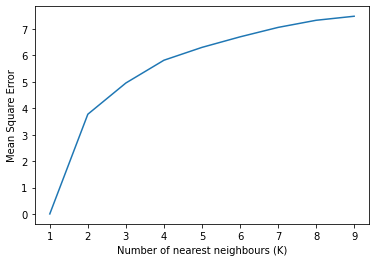

In [82]:
import matplotlib.pyplot as plt

def Validation_Curve(k):
  mse_list=list()
  for k in range(1,k):
    mse_list.append((evaluate(k,False),k))
  plt.plot(list(range(1,10)),list(list(zip(*mse_list))[0]))
  plt.xlabel("Number of nearest neighbours (K)")
  plt.ylabel("Mean Square Error")
  plt.show()
  mse_list.sort(key=lambda item:item[0])
  return mse_list[0][1]

opt_K = Validation_Curve(10)

The number of nearest neighbours (k) is plotted on the x-axis and the average error on the test data is plotted on the y-axis!

As we can see in Graph, as K increases, the validation error is increasing because model is overfitting with more K.


We pick k = 4 (even though there is no clear value), by the elbow method! After k=4, there is not much reduction in the mean squared error when k increases!

In [88]:
opt_K = 4
print("Selected k = ", opt_K)

Selected k =  4


## Q4: Generalization Error

`gen_error` is error rate on test test with different folds. The K used will be the one that is found earlier.

folds- Number of folds to test

Outputs the mean square error for each fold.

In [89]:
import numpy as np

def gen_error(n_fold)-> float:
  test_y_hat=list()
  mse_list=list()
  y=list()
  for cv in range(n_fold):
    train, test = create_train_test(folds, cv)
    for t in test:      
      test_y_hat.append(knn(dataset=train,query=t[:7], k=opt_K))
      y.append(t[8])
    mse_list.append(mse(y,test_y_hat)**0.5)
    y.clear()
    test_y_hat.clear()
  for cv,m in enumerate(mse_list):
    print(f"Generalized Error for Fold={cv} is {m} ")
  print(f"Mean Error is {np.mean(mse_list)}")
  return np.mean(mse_list)


In [90]:
gen_error(10)

Generalized Error for Fold=0 is 12.863906569662642 
Generalized Error for Fold=1 is 12.741276922716938 
Generalized Error for Fold=2 is 12.515423879788358 
Generalized Error for Fold=3 is 14.666451528053994 
Generalized Error for Fold=4 is 12.830007704369267 
Generalized Error for Fold=5 is 12.085705243711024 
Generalized Error for Fold=6 is 13.56521392022464 
Generalized Error for Fold=7 is 13.626822706976803 
Generalized Error for Fold=8 is 11.649461918279181 
Generalized Error for Fold=9 is 13.754850170613253 
Mean Error is 13.02991205643961


13.02991205643961

## Q5: Choose your own adventure

You have three options for the next part:

1. You can implement mean normalization (also called "z-score standardization") of the *features*; do not normalize the target, y. See if this improves the generalization error of your model (middle).

2. You can implement *learning curves* to see if more data would likely improve your model (easiest).

3. You can implement *weighted* kNN and use the real valued GA to choose the weights. weighted kNN assigns a weight to each item in the Euclidean distance calculation. For two points, j and k:
$$\sqrt{\sum w_i (x^k_i - x^j_i)^2}$$

You can think of normal Euclidean distance as the case where $w_i = 1$ for all features  (ambitious, but fun...you need to start EARLY because it takes a really long time to run).

The easier the adventure the more correct it must be...

## Learning Curves

`learning_curve()` Constructs the Learning curve for different values of K, a plot with increasing model Complexity. 

Outputs a Matplotib Curve with

X_axis = K

Y_axis = Mean Square Error

Returns Variance

In [29]:
def learning_curve()->float:
  mse_list=list()
  test_y_hat=list()
  y=list()
  for k in range(1,20):
    for t in test:
      test_y_hat.append(knn(dataset=train,query=t[:7], k=k))
      y.append(t[8])
    mse_list.append(mse(y,test_y_hat)**0.5)
    y.clear()
    test_y_hat.clear()    
  plt.plot(list(range(1,20)),mse_list)
  plt.xlabel("Number of nearest neighbours (K)")
  plt.ylabel("Mean Square Error")
  plt.show()
  ys = [item[8] for item in test]
  y_means = [mean(ys) for _ in test]
  variance=mse(ys, y_means)
  print(f"Variance is: {variance}")
  return variance

#Overfitting

There is clearly overfitting because of high error at lower K and high population variance in prediction. More data will be required to decrease variance. 

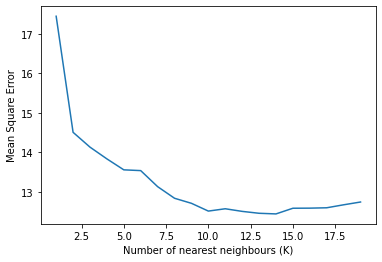

Variance is: 287.1329790555187


In [30]:
assert(type(learning_curve()))==float

## Before You Submit...

1. Did you provide output exactly as requested?
2. Did you re-execute the entire notebook? ("Restart Kernel and Rull All Cells...")
3. If you did not complete the assignment or had difficulty please explain what gave you the most difficulty in the Markdown cell below.
4. Did you change the name of the file to `jhed_id.ipynb`?

Do not submit any other files.

In [1]:
import streamlit as st

2022-02-16 04:54:17.253 INFO    numexpr.utils: NumExpr defaulting to 4 threads.


ImportError: dlopen(/Users/bnjasim/miniconda3/lib/python3.8/site-packages/pyarrow/lib.cpython-38-darwin.so, 2): Symbol not found: _SSLCopyALPNProtocols
  Referenced from: /Users/bnjasim/miniconda3/lib/python3.8/site-packages/pyarrow/libarrow.700.dylib
  Expected in: /System/Library/Frameworks/Security.framework/Versions/A/Security
 in /Users/bnjasim/miniconda3/lib/python3.8/site-packages/pyarrow/libarrow.700.dylib

In [2]:
import pyarrow

ImportError: dlopen(/Users/bnjasim/miniconda3/lib/python3.8/site-packages/pyarrow/lib.cpython-38-darwin.so, 2): Symbol not found: _SSLCopyALPNProtocols
  Referenced from: /Users/bnjasim/miniconda3/lib/python3.8/site-packages/pyarrow/libarrow.700.dylib
  Expected in: /System/Library/Frameworks/Security.framework/Versions/A/Security
 in /Users/bnjasim/miniconda3/lib/python3.8/site-packages/pyarrow/libarrow.700.dylib